<a href="https://colab.research.google.com/github/Zarif123/Img-to-Ingredients/blob/main/foodDataColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# pytorch imports
import torch
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import random
from tqdm import tqdm_notebook as tqdm
import math
import time
from IPython.core.debugger import set_trace

In [36]:
print("cuda" if torch.cuda.is_available() else "cpu")
bs = 64
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]

cuda


In [37]:
FOOD_PATH = "/content/drive/MyDrive/IEEE/food-101"
IMG_PATH = FOOD_PATH+"/images"
META_PATH = FOOD_PATH+"/meta"
TRAIN_PATH = FOOD_PATH+"/train"
VALID_PATH = FOOD_PATH+"/valid"
MODEL_PATH = 'model_data/'

In [38]:
filename = MODEL_PATH+'clr.pth'

In [39]:
def pp_(*args, n_dash=120):
    for arg in args:
        print(arg)
        print("-"*n_dash)

def list_dir(path="./"): return os.listdir(path)

def cal_mean_std(train_data):
    return np.mean(train_data, axis=(0,1,2))/255, np.std(train_data, axis=(0,1,2))/255

def save_checkpoint(model, is_best, filename='model_data/checkpoint.pth'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")
        
# from fastai library
def load_checkpoint(model, filename = 'model_data/checkpoint.pth'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()): 
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)        

def save_model(model, path):
    torch.save(model.state_dict(), path)
    
def load_model(model, path):
    model.load_state_dict(torch.load(path))    

def calc_iters(dataset, num_epochs, bs):
    return int(len(dataset) * num_epochs /bs)

def accuracy(output, target, is_test=False):
    global total
    global correct
    batch_size = output.shape[0]
    total += batch_size
    
    _, pred = torch.max(output, 1)
    if is_test:
        preds.extend(pred)
    correct += (pred == target).sum()
    return 100 * correct / total

class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.precs =[]
        self.its = []
        
    def append(self, loss, prec, it):
        self.losses.append(loss)
        self.precs.append(prec)
        self.its.append(it)

def freeze(model):
    child_counter = 0
    for name, child in model.named_children():
        if child_counter < 7:
            print("name ",name, "child ",child_counter," was frozen")
            for param in child.parameters():
                param.requires_grad = False
        elif child_counter == 7:
            children_of_child_counter = 0
            for children_of_child in child.children():
                if children_of_child_counter < 2:
                    for param in children_of_child.parameters():
                        param.requires_grad = False
                    print("name ",name, 'child ', children_of_child_counter, 'of child',child_counter,' was frozen')
                else:
                    print("name ",name, 'child ', children_of_child_counter, 'of child',child_counter,' was not frozen')
                children_of_child_counter += 1

        else:
            print("name ",name, "child ",child_counter," was not frozen")
        child_counter += 1

def unfreeze(model):
    for param in model.parameters():
        param.requires_grad = True

def print_frozen_state(model):
    child_counter = 0
    for name, child in model.named_children():
        for param in child.parameters():
            if param.requires_grad == True:
                print("child ",child_counter,"named:",name," is unfrezed")
            elif param.requires_grad == False:
                print("child ",child_counter,"named:",name," is frezed")
        child_counter += 1

def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom



In [40]:
class FOOD101():
    
    
    def __init__(self):
        self.bs = 64
        self.epochs = 3
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]
        self.train_ds, self.valid_ds, self.train_cls, self.valid_cls = [None]*4
        self.imgenet_mean = self.imagenet_stats[0]
        self.imgenet_std = self.imagenet_stats[1]
   
    def get_data_extract(self):
        if "food-101" in os.listdir():
            print("Dataset already exists")
        else:
            print("Downloading the data...")
            #wget.download("http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz")
            print("Dataset downloaded!")
            print("Extracting data..")
            # !tar xzvf food-101.tar.gz
            print("Extraction done!")
        
    def _get_tfms(self):
        train_tfms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(),
            transforms.Normalize(self.imgenet_mean, self.imgenet_std)])
        
        valid_tfms = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(self.imgenet_mean, self.imgenet_std)])        
        return train_tfms, valid_tfms            
            
    def get_dataset(self,root_dir='./food-101/'):
        train_tfms, valid_tfms = self._get_tfms() # transformations
        self.train_ds = datasets.ImageFolder(root=TRAIN_PATH, transform=train_tfms)
        self.valid_ds = datasets.ImageFolder(root=VALID_PATH, transform=valid_tfms)        
        self.train_classes = self.train_ds.classes
        self.valid_classes = self.valid_ds.classes

        assert self.train_classes==self.valid_classes
        return self.train_ds, self.valid_ds, self.train_classes

    
    def get_dls(self, train_ds, valid_ds, bs, **kwargs):
        return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
               DataLoader(valid_ds, batch_size=bs//2, shuffle=False, **kwargs))
    
food = FOOD101()    

In [41]:
pp_(list_dir(FOOD_PATH), list_dir(IMG_PATH), list_dir(META_PATH))

['images', 'meta', 'train', 'valid']
------------------------------------------------------------------------------------------------------------------------
['samosa', 'sashimi', 'spring_rolls', 'panna_cotta', 'greek_salad', 'foie_gras', 'tacos', 'pad_thai', 'ramen', 'pulled_pork_sandwich', 'beignets', 'crab_cakes', 'steak', 'frozen_yogurt', 'club_sandwich', 'carrot_cake', 'falafel', 'chicken_wings', 'chocolate_cake', 'tiramisu', 'garlic_bread', 'scallops', 'edamame', 'pancakes', 'red_velvet_cake', 'deviled_eggs', 'peking_duck', 'guacamole', 'clam_chowder', 'french_onion_soup', 'beef_carpaccio', 'donuts', 'french_fries', 'shrimp_and_grits', 'dumplings', 'tuna_tartare', 'takoyaki', 'breakfast_burrito', 'waffles', 'seaweed_salad', 'pizza', 'prime_rib', 'ice_cream', 'pho', 'lobster_roll_sandwich', 'nachos', 'oysters', 'escargots', 'strawberry_shortcake', 'apple_pie', 'lobster_bisque', 'bread_pudding', 'grilled_cheese_sandwich', 'filet_mignon', 'chicken_curry', 'mussels', 'hot_dog', 'chic

In [42]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src, dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')
    print(classes_images.keys())

    for food in classes_images.keys():
        if food in list_dir(IMG_PATH):
          print("\nCopying images into ",food)
          if not os.path.exists(os.path.join(dest,food)):
              os.makedirs(os.path.join(dest,food))
          else:
            continue
          for i in classes_images[food]:
              try:
                copy(os.path.join(src,food,i), os.path.join(dest,food,i))
              except:
                pass
    print("Copying Done!")

In [43]:
#prepare_data(META_PATH+'/train.txt', IMG_PATH, TRAIN_PATH)
#prepare_data(META_PATH+'/test.txt', IMG_PATH, VALID_PATH)

In [44]:
train_ds, valid_ds, classes =  food.get_dataset()
pp_(classes)

['apple_pie', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'carrot_cake', 'cheese_plate', 'cheesecake', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'greek_salad', 'grilled_cheese_sandwich', 'guacamole', 'hamburger', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'miso_soup', 'mussels', 'onion_rings', 'oysters', 'pad_thai', 'pancakes', 'panna_cotta', 'pho', 'pizza', 'pork_chop', 'prime_rib', 'ramen', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spring_rolls', 'steak', 'strawberry_shortcake', 

In [45]:
train_dl, valid_dl = food.get_dls(train_ds, valid_ds, bs=bs, num_workers=2)

In [46]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl, self.valid_dl, self.c = train_dl, valid_dl, c
    
    @property
    def train_ds(self): return self.train_dl.dataset
    
    @property
    def valid_ds(self): return self.valid_dl.dataset
    
    def __repr__(self):
        return str(self.__class__.__name__)+" obj (train & valid DataLoaders)"

In [47]:
data = DataBunch(train_dl, valid_dl, c=num_classes)

In [48]:
pp_(data.valid_ds, data.c, data.train_ds)

Dataset ImageFolder
    Number of datapoints: 17582
    Root location: /content/drive/MyDrive/IEEE/food-101/valid
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
------------------------------------------------------------------------------------------------------------------------
72
------------------------------------------------------------------------------------------------------------------------
Dataset ImageFolder
    Number of datapoints: 53015
    Root location: /content/drive/MyDrive/IEEE/food-101/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
 

In [49]:
def show_ds(trainset, classes, validset=None, cols=6, rows=17, preds=None, is_pred=False, is_valid=False):        
    fig = plt.figure(figsize=(25,25))
    fig.suptitle(f"Showing one random image from each {'Validation' if is_valid else 'Train'} classes", y=0.92, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
    columns = cols
    rows = rows
    
    imgenet_mean = imagenet_stats[0]
    imgenet_std = imagenet_stats[1]  

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        
        if is_pred and testset:
            img_xy = np.random.randint(len(testset));
            np_img = testset[img_xy][0].numpy()
            img = np.transpose(np_img, (1,2,0))            
            img = img * imgenet_std + imgenet_mean
        else:
            img_xy = np.random.randint(len(trainset));
            np_img = trainset[img_xy][0].numpy()
            img = np.transpose(np_img, (1,2,0))
            img = img * imgenet_std + imgenet_mean
        
        if is_pred:
            plt.title(classes[int(preds[img_xy])] + "/" + classes[testset[img_xy][1]])
        else:
            plt.title(classes[trainset[img_xy][1]])
        plt.axis('off')
        img = np.clip(img, 0, 1)
        plt.imshow(img, interpolation='nearest')
    plt.show()

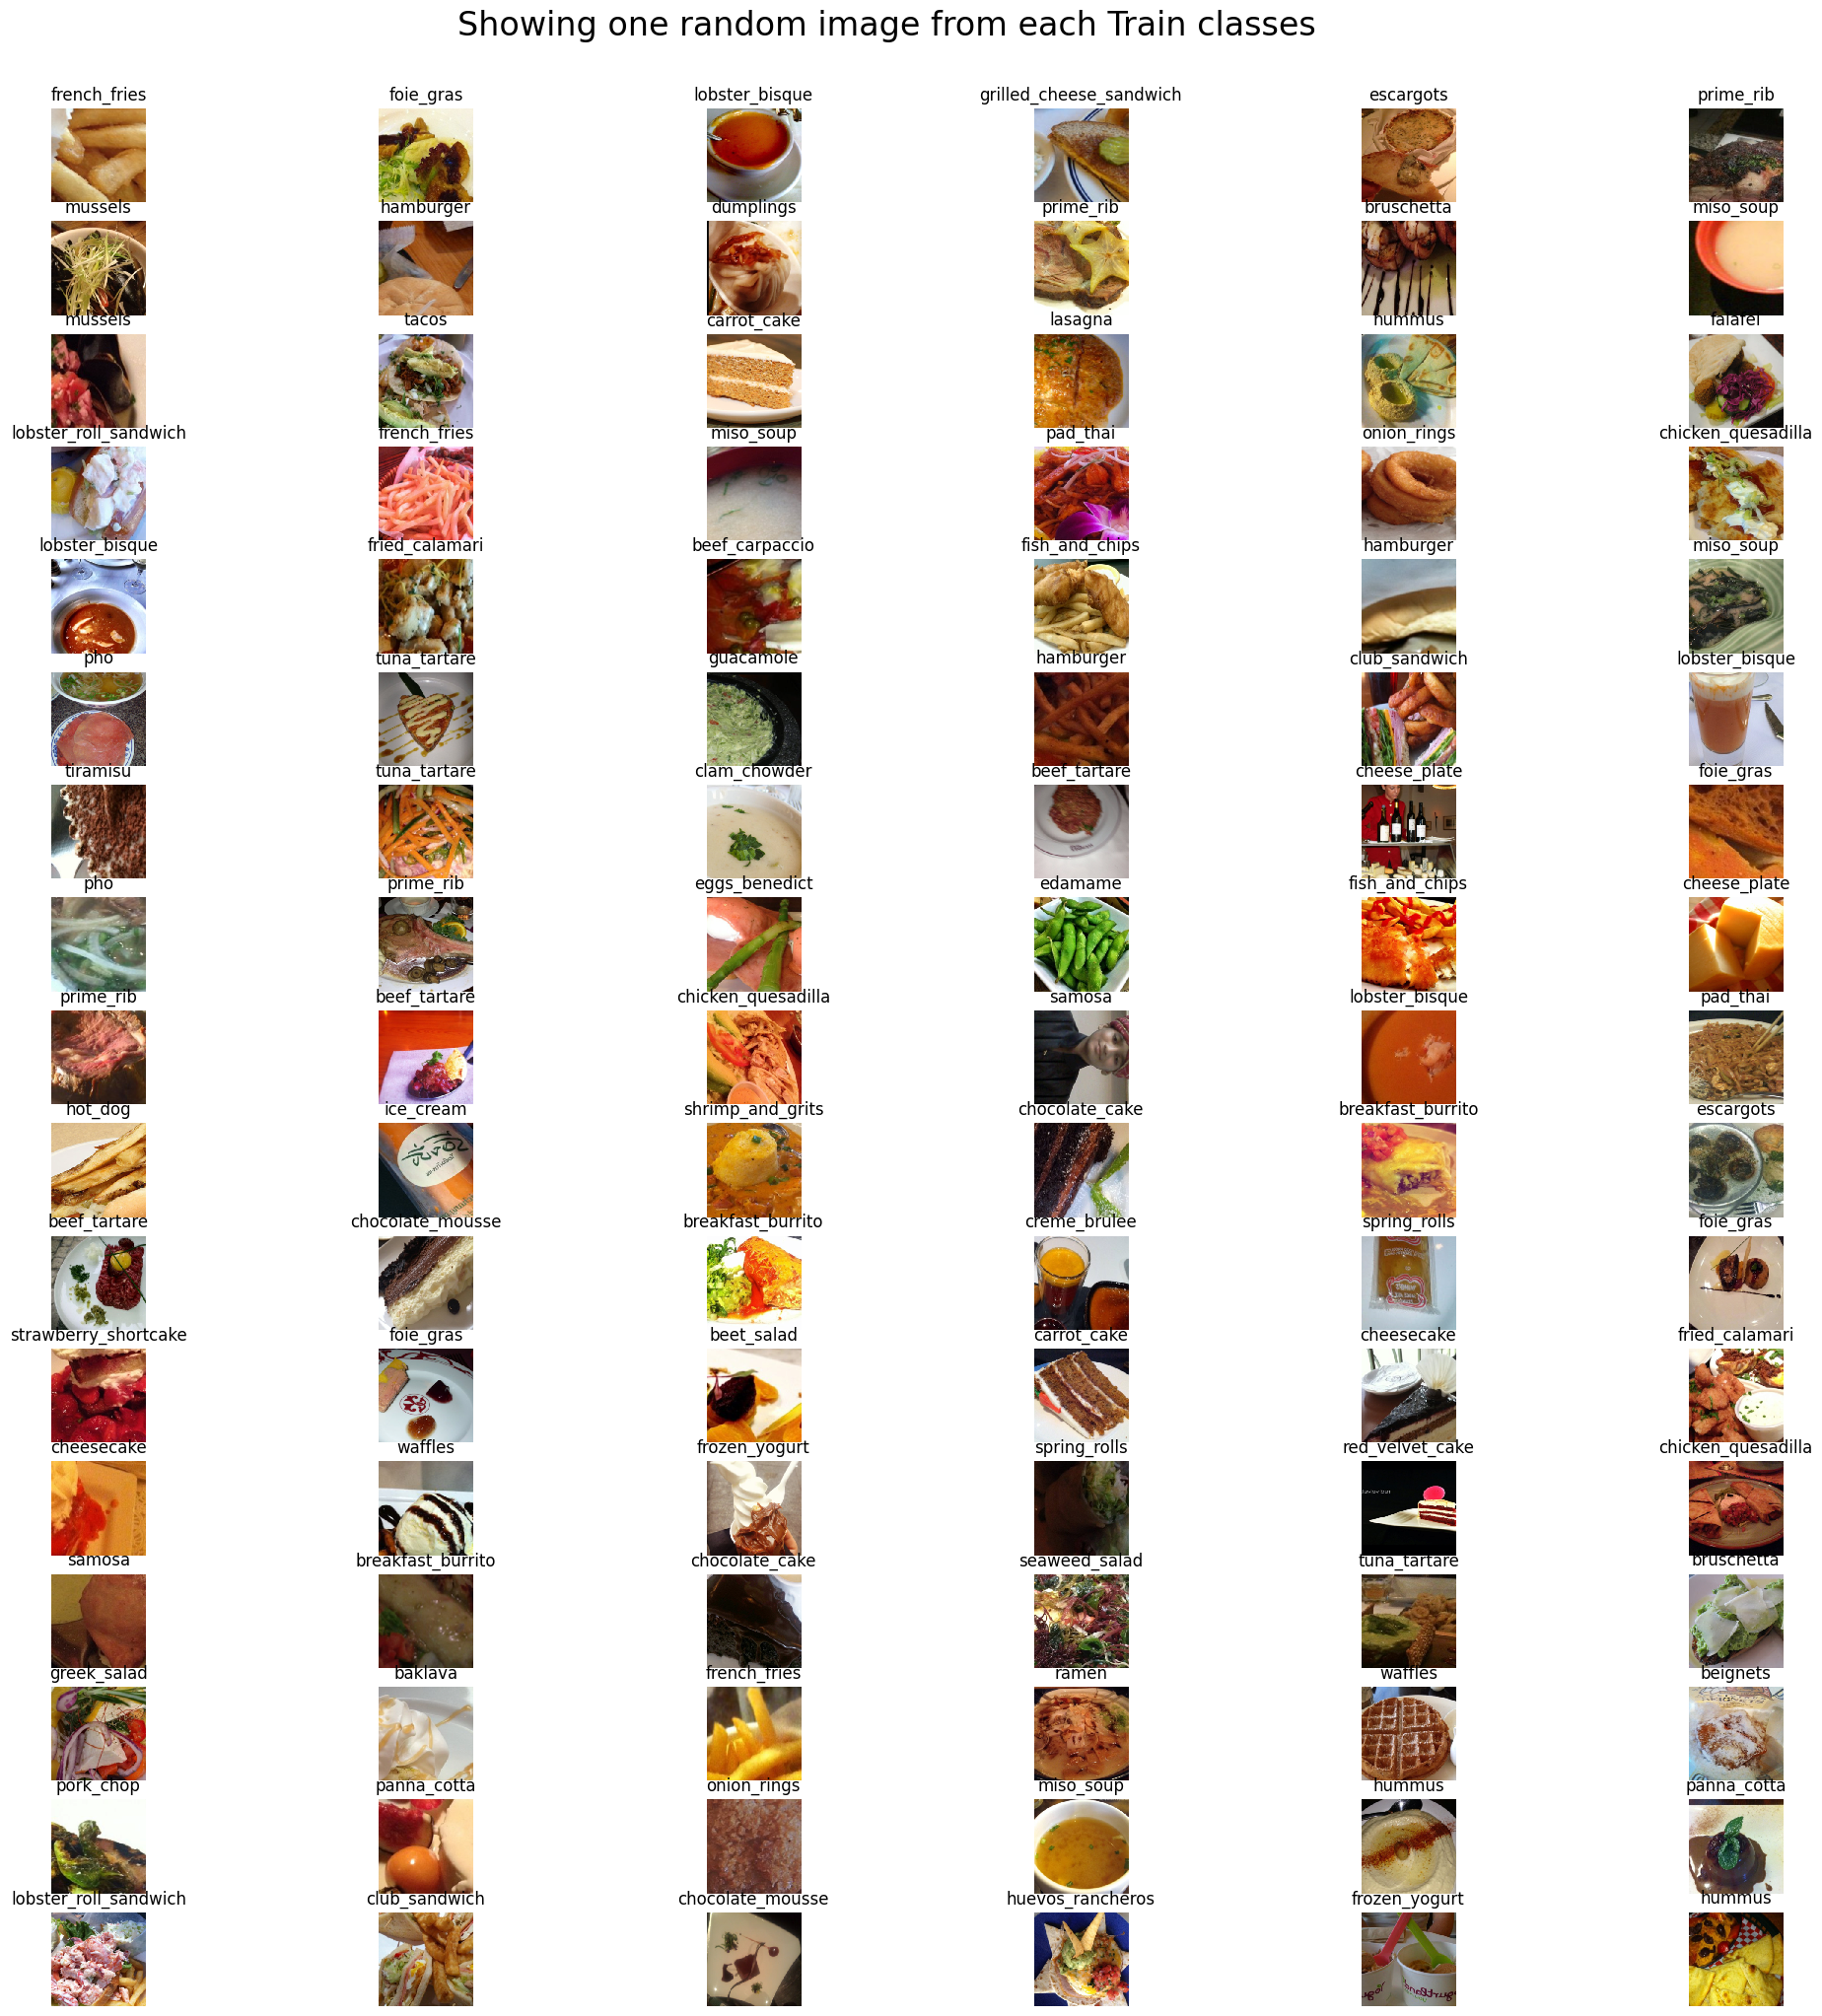

In [50]:
show_ds(data.train_ds, classes)

In [51]:
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms

In [52]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # convolutional layers
        self.pool = nn.MaxPool2d(2, 2) # size of pool for image
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120) # this down is all the hidden layrs
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 101)

    def forward(self, x):
        # print(x.size())
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.size())
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x)) # activation functions
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [53]:
print(data.train_ds[1][0].size())

torch.Size([3, 224, 224])


In [60]:
def train_one_epoch(model, train_data_loader, optimizer, criterion):
    #print(data.size())
    cur_loss = 0
    cur_acc = 0
    num_batches = len(train_data_loader)
    num_samples = 60
    for batch_idx, (train_features, train_labels) in enumerate(train_data_loader):
      try:
        optimizer.zero_grad()
        # print(f"Train Features: {train_features[0]}")
        try:
            logit_output = model(train_features.to(device))
        except:
            continue
        # print(logit_output)
        # print(train_labels)
        loss = criterion(logit_output, train_labels.to(device))
        preds = torch.argmax(logit_output, dim=1)
        # print(preds)
        truth = train_labels
        # print(f"Logit Output = {logit_output}")
        # print(f"Preds = {preds}\nLabels = {train_labels}; Truth = {truth}\n")

        loss.backward()
        optimizer.step()
        if batch_idx == num_samples:
            break
        cur_loss += loss.item()
        if batch_idx % 10 == 0:
          print(f"Batch {batch_idx} done")
      except:
        continue
    

    # Shapes of output and targets
    # print(f"Output size: {probs.size()}")
    # print(f"Target size: {train_labels.size()}")

    # loss = F.mse_loss(output.float(), targets.float())
    # output = torch.argmax(output, dim=1)

    av_loss = cur_loss / num_batches
    av_acc = cur_acc / num_batches
    return av_loss, av_acc

In [61]:
def train_loop(model, epochs, optimizer, criterion, train_dl):
    loss_over_time = [0 for i in range(epochs)]
    acc_over_time = [0 for i in range(epochs)]
    for epoch in range(epochs):
        model.train(True)
        av_loss, av_acc = train_one_epoch(model, train_dl, optimizer, criterion)
        loss_over_time[epoch] = av_loss
        acc_over_time[epoch] = av_acc
        print(f"Epoch: {epoch}, Average Loss: {av_loss}")
        
def validation_loop(model, valid_dl):
    correct = 0
    num_data = len(valid_dl)
    num_samples = 60
    for batch_idx, (valid_features, valid_labels) in enumerate(valid_dl):
        pred = model(valid_features.to(device))
        ans = torch.argmax(pred, dim=1)
        valid_labels = np.array(valid_labels)
        ans = np.array(ans)
        correct += sum(ans == valid_labels)
        print(f"Tested batch {batch_idx}")
        if batch_idx == num_samples:
            break
    return float(float(correct) / float(num_data))

In [62]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
net = net.to(device)

def main():
    train_loop(net, 3, optimizer, criterion, train_dl)
    print(validation_loop(net, valid_dl))

In [ ]:
main()

Batch 0 done
Batch 10 done


In [ ]:
print(validation_loop(net, valid_dl))